Creating DMSPhenotype and Fitness objects

In [1]:
from gcdyn.fitness import Fitness
from gcdyn.phenotype import DMSPhenotype
from Bio import SeqIO

In [2]:
dms_phenotype = DMSPhenotype(
    1,
    1,
    336,
    "https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv",
    "tdms-linear.model",
    ["delta_log10_KD", "expression", "delta_psr"],
    -10.43,
)


fasta_path = "gcreplay_samples/gctree_PR1.2-5-LP-78-GC.fasta"
seqs = [
    str(seq_record.seq)
    for seq_record in SeqIO.parse(fasta_path, "fasta")
    if seq_record.id != "naive"
]

fit = Fitness(Fitness.sigmoidal_fitness)
fitness_df = fit.normalized_fitness_df(seqs, calculate_KD=dms_phenotype.calculate_KD)

Testing different antigen concentrations vs antigen bound

/Users/alyssa/miniconda3/envs/gcdyn_39/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/alyssa/miniconda3/envs/gcdyn_39/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 12 rows containing missing values.


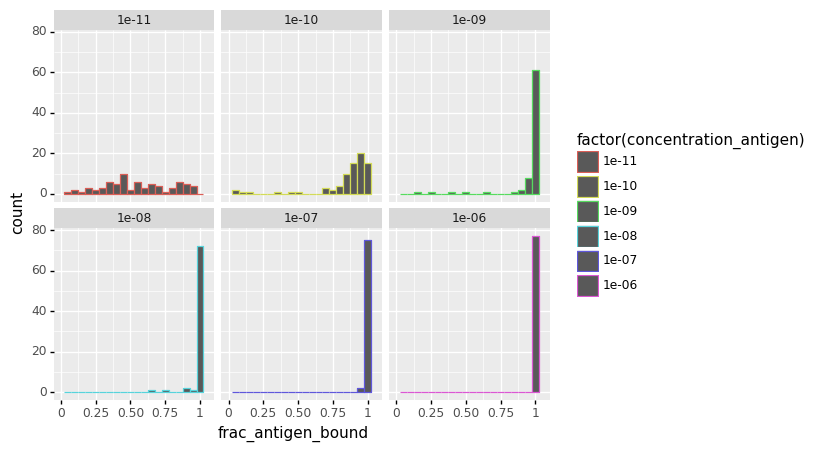

<ggplot: (8781628424635)>

In [3]:
import pandas as pd
from plotnine import ggplot, geom_histogram, aes, facet_wrap, ggtitle, xlim, ylim

antigen_bound_fracs = []
concentrations = []


def frac_antigen_bound(
    sequence_KDs: list[float], concentration_antigen: int
) -> list[float]:
    thetas = []
    for seq_KD in sequence_KDs:
        theta = concentration_antigen / (seq_KD + concentration_antigen)
        thetas.append(theta)
    return thetas


for c in range(6, 12):  # concentration of antigen from 10^-6 to 10^-10
    concentration_antigen = 10 ** (-1 * c)
    fit = Fitness(Fitness.sigmoidal_fitness, concentration_antigen)
    antigen_bound_fracs.extend(
        frac_antigen_bound(fitness_df["KD"], concentration_antigen)
    )
    concentrations.extend([concentration_antigen] * len(fitness_df["KD"]))

antigen_bound_df = pd.DataFrame(
    {"concentration_antigen": concentrations, "frac_antigen_bound": antigen_bound_fracs}
)

(
    ggplot(antigen_bound_df)
    + facet_wrap(facets="~concentration_antigen")
    + aes(x="frac_antigen_bound", color="factor(concentration_antigen)")
    + geom_histogram(binwidth=0.05)
    + xlim(0, 1.05)
)

Mapping to fitness (sigmoidal)

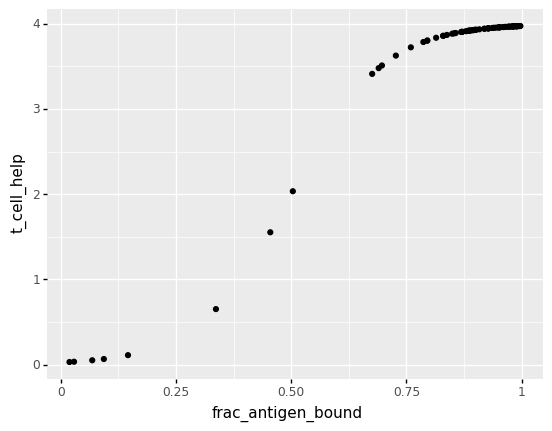

<ggplot: (8781628885983)>

In [4]:
from plotnine import geom_point

fitness_df["frac_antigen_bound"] = frac_antigen_bound(fitness_df["KD"], 10**-10)
ggplot(fitness_df) + aes(x="frac_antigen_bound", y="t_cell_help") + geom_point()

Normalized fitness (T cell help)

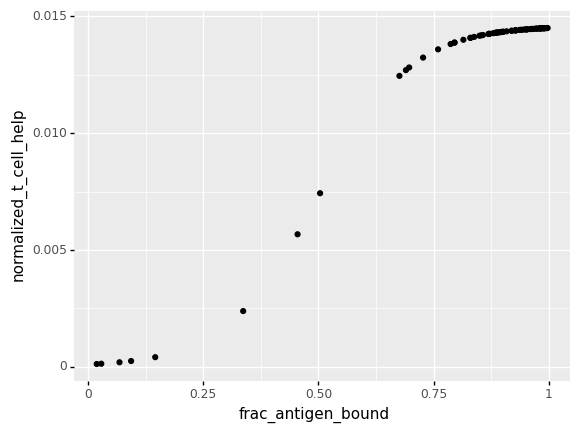

<ggplot: (8781628898618)>

In [5]:
(
    ggplot(fitness_df)
    + aes(x="frac_antigen_bound", y="normalized_t_cell_help")
    + geom_point()
)

In [6]:
print(fitness_df)

                                                  seq            KD  \
0   GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...  9.860995e-11   
1   GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...  3.842106e-12   
2   GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...  1.368036e-09   
3   GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...  7.789016e-12   
4   GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...  1.480630e-11   
..                                                ...           ...   
72  GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...  1.935265e-11   
73  GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...  4.978401e-12   
74  GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...  3.411965e-12   
75  GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...  8.783103e-12   
76  GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...  1.500293e-11   

    t_cell_help  normalized_t_cell_help  frac_antigen_bound  
0      2.034991                0.007430            0.503499  
1      3.961358        

Map to fitness (linear)

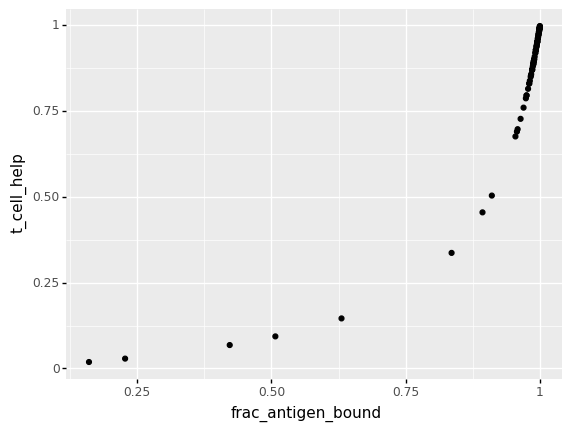

<ggplot: (8781628868280)>

In [7]:
linfit = Fitness(Fitness.linear_fitness)
linfit_fitness_df = linfit.normalized_fitness_df(
    seqs, calculate_KD=dms_phenotype.calculate_KD
)
linfit_fitness_df["frac_antigen_bound"] = frac_antigen_bound(
    linfit_fitness_df["KD"], 10**-9
)
ggplot(linfit_fitness_df) + aes(x="frac_antigen_bound", y="t_cell_help") + geom_point()

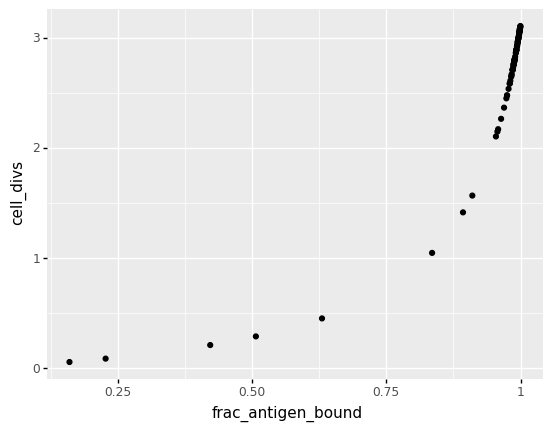

<ggplot: (8781629016140)>

In [8]:
# map normalized fitness linearly to number of cell divisions
test_cell_divs = linfit.cell_divisions_from_tfh_linear(
    linfit_fitness_df["normalized_t_cell_help"], 200
)
linfit_fitness_df["cell_divs"] = test_cell_divs
ggplot(linfit_fitness_df) + aes(x="frac_antigen_bound", y="cell_divs") + geom_point()

Uniform fitness

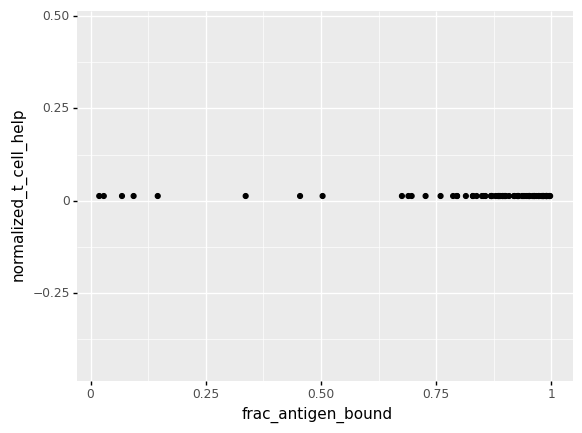

<ggplot: (8781629156048)>

In [9]:
uniform_fit = Fitness(Fitness.uniform_fitness)
uniform_fitness_df = uniform_fit.normalized_fitness_df(
    seqs, calculate_KD=dms_phenotype.calculate_KD
)
uniform_fitness_df["frac_antigen_bound"] = frac_antigen_bound(
    uniform_fitness_df["KD"], 10**-10
)
(
    ggplot(uniform_fitness_df)
    + aes(x="frac_antigen_bound", y="normalized_t_cell_help")
    + geom_point()
)